# Chapter 22 
 Machine Learning for Business Analytics<br>
Concepts, Techniques, and Applications in Python<br>
by Galit Shmueli, Peter C. Bruce, Peter Gedeck, Nitin R. Patel

Publisher: Wiley; 2nd edition (2024) <br>
<!-- ISBN-13: 978-3031075650 -->

(c) 2024 Galit Shmueli, Peter C. Bruce, Peter Gedeck, Nitin R. Patel

The code needs to be executed in sequence.

Python packages and Python itself change over time. This can cause warnings or errors.
"Warnings" are for information only and can usually be ignored.
"Errors" will stop execution and need to be fixed in order to get results.

If you come across an issue with the code, please follow these steps

- Check the repository (https://gedeck.github.io/sdsa-code-solutions/) to see if the code has been upgraded. This might solve the problem.
- Report the problem using the issue tracker at https://github.com/gedeck/sdsa-code-solutions/issues
- Paste the error message into Google and see if someone else already found a solution

In [2]:
import matplotlib.pyplot as plt
import mlba
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

In [3]:
compas_df = mlba.load_data("COMPAS-clean.csv")

predictors = ['age_cat', 'c_charge_degree', 'sex', 'priors_count', 'race']
outcome = 'two_year_recid'
train_X, holdout_X, train_y, holdout_y = train_test_split(
    compas_df[predictors], compas_df[outcome],
    test_size=0.30, random_state=1)

 
We include `race` column, but will ignore it in the model as you can see in the preprocess step. We require this for our analysis of model performance by race.

In [4]:
preprocess = ColumnTransformer([
    ('age', OneHotEncoder(drop=['Less than 25']), ['age_cat']),
    ('c_charge_degree', OneHotEncoder(drop=['F']), ['c_charge_degree']),
    ('sex', OneHotEncoder(drop=['Female']), ['sex']),
    ('numerical', 'passthrough', ['priors_count']),
], verbose_feature_names_out=False)

lr_model = Pipeline([
    ('preprocess', preprocess),
    ('clf', LogisticRegression()),
])
lr_model.fit(train_X, train_y)

rf_model = Pipeline([
    ('preprocess', preprocess),
    ('clf', RandomForestClassifier(random_state=123)),
])
rf_model.fit(train_X, train_y)

coefficients = lr_model['clf'].coef_[0]
print(pd.DataFrame({
    'coefficient': [lr_model['clf'].intercept_[0], *coefficients],
    'odds': [np.nan, *np.exp(coefficients)],
}, index=['intercept', *lr_model['preprocess'].get_feature_names_out()]))

                         coefficient      odds
intercept                  -0.660975       NaN
age_cat_25 - 45            -0.772721  0.461755
age_cat_Greater than 45    -1.465373  0.230992
c_charge_degree_M          -0.149461  0.861172
sex_Male                    0.481756  1.618914
priors_count                0.166605  1.181288


 
We use the `ColumnTransformer` class to apply different preprocessing steps to different columns. This allows us to define the specific category we want to use as the reference group. For example, for the age category (`age_cat`), we drop the category `Less than 25` to use it as the reference group. The numerical predictor `priors_count` is passed through without any transformation.

After model is fitted, we can get information about the generated features using the method `get_feature_names_out()` from the `preprocess` object. By default, the feature names would include the name of the original column and the category. We can set the parameter `verbose_feature_names_out` to `False` to get only the category name which is sufficient for our purposes.

In [5]:
def calculate_metrics(model, X, y):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    return {
        'AUC': metrics.roc_auc_score(y, y_prob),
        'Accuracy': metrics.accuracy_score(y, y_pred),
        'FPR': 100 * (1 - metrics.recall_score(y, y_pred, pos_label=0)),
        'FNR': 100 * (1 - metrics.recall_score(y, y_pred, pos_label=1)),
    }

def calculate_metrics_byrace(model, X, y, model_name):
    byrace = []
    for race, X_byrace in X.groupby('race'):
        if race in ['Asian', 'Native American']:
            continue
        y_byrace = y.loc[X_byrace.index]
        byrace.append({
            'model': model_name,
            'race': race,
            **calculate_metrics(model, X_byrace, y_byrace),
        })
    return byrace

 
Calculate the performance of the null-model; a classifier that always predicts the majority class. This is a useful baseline to compare the performance of the model.

In [6]:
from sklearn.dummy import DummyClassifier
null_model = DummyClassifier(strategy='most_frequent')
null_model.fit(train_X, train_y)
calculate_metrics(null_model, holdout_X, holdout_y)

{'AUC': 0.5, 'Accuracy': 0.6400753768844221, 'FPR': 0.0, 'FNR': 100.0}

 
Calculate the overall performance of the model on the holdout dataset.

In [7]:
print(pd.DataFrame({
    'Null model': calculate_metrics(null_model, holdout_X, holdout_y),
    'Logistic regression': calculate_metrics(lr_model, holdout_X, holdout_y),
    'Random forest': calculate_metrics(rf_model, holdout_X, holdout_y),
}).round(3))

          Null model  Logistic regression  Random forest
AUC             0.50                0.718          0.711
Accuracy        0.64                0.697          0.695
FPR             0.00               10.206         20.412
FNR           100.00               66.143         48.517


 
Calculate the performance of both models by race.

In [8]:
metrics_byrace = pd.DataFrame([
    *calculate_metrics_byrace(lr_model, holdout_X, holdout_y, 'Logistic regression'),
    *calculate_metrics_byrace(rf_model, holdout_X, holdout_y, 'Random forest'),
])

In [9]:
metrics_byrace.round(2)

,model,race,AUC,Accuracy,FPR,FNR
0,Logistic regression,African-American,0.72,0.68,14.04,56.65
1,Logistic regression,Caucasian,0.69,0.72,6.44,79.75
2,Logistic regression,Hispanic,0.70,0.70,8.24,76.92
3,Logistic regression,Other,0.77,0.69,6.06,89.29
4,Random forest,African-American,0.71,0.68,25.96,40.46
5,Random forest,Caucasian,0.68,0.70,17.01,60.76
6,Random forest,Hispanic,0.73,0.74,10.59,58.97
7,Random forest,Other,0.74,0.73,12.12,60.71


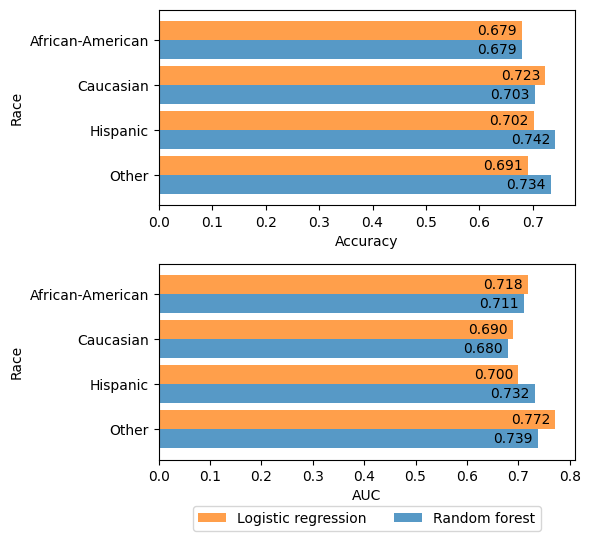

In [10]:
def plot_metrics_byrace(metrics_byrace, ax, metric):
  df = (metrics_byrace
        .pivot_table(columns='model', index='race')
        .reset_index())
  df.plot.barh(x='race', y=metric, ax=ax, width=0.85, alpha=0.75, color=['C1', 'C0'])
  print()
  for p in ax.patches:
      ax.annotate(f'{p.get_width():.3f}', (p.get_width()-0.01,  p.get_y() + p.get_height() * 0.5),
                  ha='right', va='center', color='black', fontsize=10)

  ax.set_xlabel(metric)
  ax.set_ylabel('Race')
  ax.invert_yaxis()

fig, axes = plt.subplots(figsize=(6, 5.5), nrows=2)
plot_metrics_byrace(metrics_byrace, axes[0], 'Accuracy')
plot_metrics_byrace(metrics_byrace, axes[1], 'AUC')

axes[0].get_legend().remove()
axes[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=2)
plt.tight_layout()
plt.show()

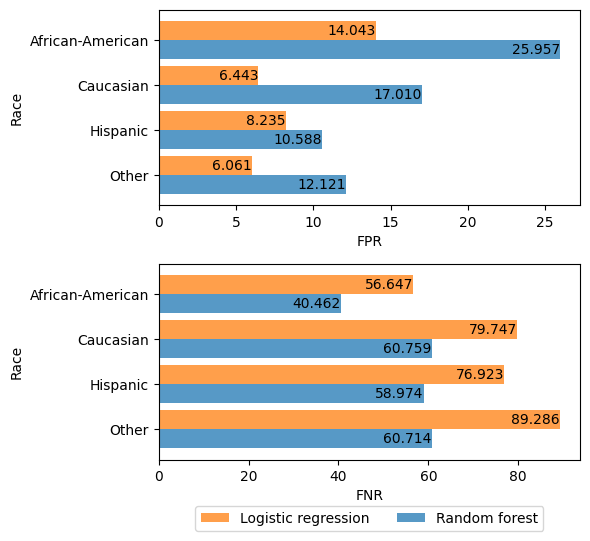

In [11]:
fig, axes = plt.subplots(figsize=(6, 5.5), nrows=2)
plot_metrics_byrace(metrics_byrace, axes[0], 'FPR')
plot_metrics_byrace(metrics_byrace, axes[1], 'FNR')

axes[0].get_legend().remove()
axes[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=2)
plt.tight_layout()
plt.show()

In [12]:
# in order to calculate PFP, we need to transform the data using the
# preprocessing steps
clf = lr_model['clf']
X_transformed = lr_model['preprocess'].transform(holdout_X)

r = permutation_importance(clf, X_transformed, holdout_y,
                            n_repeats=30,
                            random_state=0)

feature_names = lr_model['preprocess'].get_feature_names_out()
for i in r.importances_mean.argsort()[::-1]:
    print(f"{feature_names[i]:<8} "
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

priors_count 0.090 +/- 0.008
age_cat_Greater than 45 0.029 +/- 0.005
age_cat_25 - 45 0.017 +/- 0.004
sex_Male 0.003 +/- 0.003
c_charge_degree_M 0.001 +/- 0.002


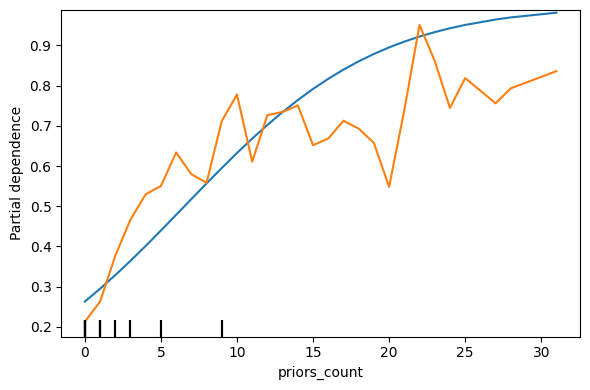

In [13]:
fig, ax = plt.subplots(figsize=(6, 4))
plot = PartialDependenceDisplay.from_estimator(lr_model, holdout_X,
    features=['priors_count'], ax=ax)
# Overlay result for random forest model
_ = PartialDependenceDisplay.from_estimator(rf_model, holdout_X,
    features=['priors_count'], ax=plot.axes_)
plot.axes_[0][0].get_lines()[1].set_color('C1')
plt.tight_layout()
plt.show()